In [2]:
import os 
import json
import pprint
import pandas as pd
from pandas import json_normalize
import numpy as np

from IPython.display import display
#from gnuplotlib import gp
import matplotlib.pyplot as plt
import autogpy
import seaborn as sns


C:\Users\larad\AppData\Local\Temp\ipykernel_14316\549442779.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [99]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_style("white")

def parseQlogFile(qlog_file_path, regex):
    f = open(qlog_file_path, 'r')
    qlog_data = f.read()
    f.close()

    records = qlog_data.strip().split(regex)
    parsedRecords = parseQlogDataRecords(records)

    transport_records = [record for record in parsedRecords[1:] if 'packet_sent' in record["name"] or 'packet_received' in record["name"]]
    parameters_set_records = [record for record in parsedRecords[1:] if 'parameters_set' in record["name"]]
    
    connection_establishment_handshake_time, tls_handshake_time, time_to_data_transfer = getHandshakeTimes(transport_records)
    error_reason = getError(transport_records)
    tls_established = getTLSInfo(parameters_set_records)
    zeroRTT = get0RTTPackets(transport_records)

    if zeroRTT > 0:
        print(zeroRTT)

    return connection_establishment_handshake_time, tls_handshake_time, time_to_data_transfer, error_reason, tls_established


def getHandshakeTimes(records):
    initial_packet_time = records[0]["time"]
    all_handshake_end_time = 0
    tls_handshake_packets, connection_establishment_handshake_packets = getHandshakePackets(records)

    # Get time of first data packet:
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type != "initial" and packet_type != "handshake":
            all_handshake_end_time = record["time"]
            break
    
    if len(connection_establishment_handshake_packets) == 0:
        return (None, None, None)
    # Get time of first data packet after connection establishment handshake:
    connection_establishment_handshake_start_time = connection_establishment_handshake_packets[0]["time"]
    connection_establishment_handshake_end_time = connection_establishment_handshake_packets[-1]["time"]
    

    if len(tls_handshake_packets) == 0:
        return (connection_establishment_handshake_end_time - connection_establishment_handshake_start_time, None, None)
    
    # Get time of first data packet after TLS handshake:
    tls_handshake_start_time = tls_handshake_packets[0]["time"]
    tls_handshake_end_time = tls_handshake_packets[-1]["time"]
    
    return (connection_establishment_handshake_end_time - connection_establishment_handshake_start_time, 
            tls_handshake_end_time - tls_handshake_start_time, 
            all_handshake_end_time - initial_packet_time)

def getHandshakePackets(records):
    tls_handshake_packets = []
    connection_establishment_handshake_packets = []

    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type == "handshake":
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "crypto":
                    #print("TLS PACKET")
                    #pprint.pprint(record)
                    tls_handshake_packets.append(record)
                else:
                    #print("CONNECTION ESTABLISHMENT PACKET")
                    #pprint.pprint(record)
                    connection_establishment_handshake_packets.append(record)
    return tls_handshake_packets, connection_establishment_handshake_packets


def getError(records):
    error_reason = ""
    for record in records:
        if "frames" in record["data"]:
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "connection_close":
                    error_reason = frame["reason"]
                    break
    return error_reason

def getTLSInfo(records):
    tls_ciphers = []
    for record in records:
        if "tls_cipher" in record["data"]:
            tls_ciphers.append(record["data"]["tls_cipher"])
    return tls_ciphers

def get0RTTPackets(records):
    num_of_0RTT_packets = 0
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type == "0RTT":
            num_of_0RTT_packets += 1
    return num_of_0RTT_packets

def parseQlogDataRecords(qlog_data):
   json_data = [json.loads(string.strip()) for string in qlog_data]
   return json_data

def createDictionary(parsed_data):
    data_dict = {}

    for data in parsed_data:
        if type(data) == dict:
            for key, value in data.items():
                if key not in data_dict:
                    data_dict[key] = [value]
                else:
                    if type(value) == dict:
                        data_dict[key].append(createDictionary(value))
                    else:
                        data_dict[key].append(value)
        else:
            return parsed_data

    
    #pprint.pprint(data_dict)
    return data_dict

def displayPandasTable(parsedRecords):
    flattened_header_data = createDictionary(parsedRecords[0])
    flattened_header_data2 = createDictionary(parsedRecords[1])
    flattened_data = createDictionary(parsedRecords[1:])

    df1 = pd.DataFrame(flattened_header_data)
    df2 = pd.DataFrame(flattened_header_data2)
    #df = pd.DataFrame({k: [flattened_data.get(k, None)] for k in keys})
    df = pd.DataFrame(flattened_data)

    df = df.fillna('')

    display(df1)
    display(df2)
    display(df)
    

def getMeanTime(times):
    return np.mean([time for time in times if time != None])

def generateOverlappedHandshakeTimeDistribution(handshake_data_quic, handshake_data_tcp, type=1):
    bins_quic = []
    bins_tcp = []
    data_quic = {"home":[], "campus": []}
    data_tcp = {"home":[], "campus": []}

    for location in handshake_data_quic:
        max_time = 0
        for url,time in handshake_data_quic[location].items():
            if time != None:
                data_quic[location].append(time)
                if time > max_time:
                    max_time = time
        bins_quic.append(int(max_time // 5))
    
    for location in handshake_data_tcp:
        max_time = 0
        for url,time in handshake_data_tcp[location].items():
            if time != None:
                data_tcp[location].append(time)
                if time > max_time:
                    max_time = time
        bins_tcp.append(int(max_time // 5))

    print(bins_quic, bins_tcp)
    showHistPlotQUICvTCP(data_quic, data_tcp, bins_quic, bins_tcp, type)

def showHistPlotQUICvTCP(data_quic, data_tcp, bins_quic, bins_tcp, type):
    if type == 1:
        colour_quic = "orange"
        colour_tcp = "purple"
    else:
        colour_quic = "dodgerblue"
        colour_tcp = "deeppink"
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True, sharex=True, dpi=100)

    #fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    sns.histplot(data_tcp["home"], color=colour_tcp, label="TCP", bins=bins_tcp[0], ax=axes[0], kde=True, alpha=0.5, stat='percent',) #log_scale=True
    sns.histplot(data_quic["home"], color=colour_quic, label="QUIC", bins=bins_quic[0], ax=axes[0], kde=True, alpha=0.5, stat='percent',) #log_scale=True
    axes[0].set_title('Measurements taken from location 1')
    axes[0].set_xlabel('Duration of Handshake (ms)')
    axes[0].set_ylabel('Percentage of Connections (%)')
    axes[0].grid(True)

    #fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    sns.histplot(data_tcp["campus"], color=colour_tcp, label="TCP", bins=bins_tcp[1], ax=axes[1], legend=True, kde=True, alpha=0.5, stat='percent',) #log_scale=True
    sns.histplot(data_quic["campus"], color=colour_quic, label="QUIC", bins=bins_quic[1], ax=axes[1], legend=True, kde=True, alpha=0.5, stat='percent',) #log_scale=True
    axes[1].set_title('Measurements taken from location 2')
    axes[1].set_xlabel('Duration of Handshake (ms)')
    axes[1].set_ylabel('Percentage of Connections (%)')
    axes[1].grid(True)

    if type == 1:
        axes[0].set_xlim(0, 200)
        axes[1].set_xlim(0, 200)
        axes[0].set_ylim(0, 45)
        axes[1].set_ylim(0, 45)
        plt.suptitle(f'Duration of Connection Establishment Handshakes with QUIC vs TCP', fontsize=14, fontweight='bold')
    else:
        axes[0].set_xlim(0, 400)
        axes[1].set_xlim(0, 400)
        axes[0].set_ylim(0, 35)
        axes[1].set_ylim(0, 35)
        plt.suptitle(f'Time elapsed before initiating data transfer with QUIC vs TCP', fontsize=14, fontweight='bold')
        
    
    plt.tight_layout()
    plt.legend()
    plt.show()

def generateHandshakeTimeDistribution(handshake_data, proto=""):
    bins = []
    data = {"home":{"urls": [], "times":[]}, "campus": {"urls": [], "times":[]}}
    for location in handshake_data:
        max_time = 0
        for url,time in handshake_data[location].items():
            if time != None:
                data[location]["urls"].append(url)
                data[location]["times"].append(time)
                
                if time > max_time:
                    max_time = time
        bins.append(int(max_time // 5))
    print(bins)
    showHistPlot(data, bins, proto)

                       
def showHistPlot(data, bins, proto):    
    fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True, sharex=True, dpi=100)
    
    sns.histplot(data["home"]["times"], color="dodgerblue", label="home", bins=bins[0], ax=axes[0], legend=True, kde=True) #log_scale=True
    axes[0].set_title('Measurements taken from location 1')
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('Count')
    axes[0].grid(True)

    sns.histplot(data["campus"]["times"], color="deeppink", label="campus", bins=bins[1], ax=axes[1], legend=True, kde=True) #log_scale=True
    axes[1].set_title('Measurements taken from location 2')
    axes[1].set_xlabel('Time (ms)')
    axes[1].grid(True)

    # Set x-axis limit for both subplots
    x_limit = 400  # Example limit
    axes[0].set_xlim(0, x_limit)
    axes[1].set_xlim(0, x_limit)

    plt.suptitle(f"Time elapsed before initiating data transmission with {proto}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def getTLSErrors(error_reasons):
    count_errors = {}
    for location in error_reasons:
        for k, v in error_reasons[location].items():
            if v != '':
                if v in count_errors:
                    count_errors[v][location] += 1
                else:
                    if location == "home":
                        count_errors[v] = {"home": 1, "campus": 0}
                    else:
                        count_errors[v] = {"home": 0, "campus": 1}
    
    data = []
    for error, counts in count_errors.items():
        data.append((error, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([('Error', ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)   


def getTLSEstablishedInfo(tls_established):    
    tls_ciphers = {}
    for location in tls_established:
        for k, v in tls_established[location].items():
            for cipher in v:
                if cipher in tls_ciphers:
                    tls_ciphers[cipher][location] += 1
                else:
                    if location == "home":
                        tls_ciphers[cipher] = {"home": 1, "campus": 0}
                    else:
                        tls_ciphers[cipher] = {"home": 0, "campus": 1}

    data = []
    for cipher, counts in tls_ciphers.items():
        if cipher != "None":
            data.append((cipher, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([('TLS Cipher', ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)
    

In [4]:
# Global variable declarations
regex = chr(30)

locations = ["home", "campus"]

handshake_times = {l:{} for l in locations}
tls_handshake_times = {l:{} for l in locations}

time_to_data_transfer = {l:{} for l in locations}

error_reasons = {l:{} for l in locations}
tls_established = {l:{} for l in locations}

In [5]:
current_location = locations[0]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/quic"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[current_location][folder], tls_handshake_times[current_location][folder], time_to_data_transfer[current_location][folder], error_reasons[current_location][folder], tls_established[current_location][folder] = parseQlogFile(f"{folder_path}/{file}", regex)
            break


In [6]:
current_location = locations[1]

# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/quic"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[current_location][folder], tls_handshake_times[current_location][folder], time_to_data_transfer[current_location][folder], error_reasons[current_location][folder], tls_established[current_location][folder] = parseQlogFile(f"{folder_path}/{file}", regex)
            break

[95, 210]


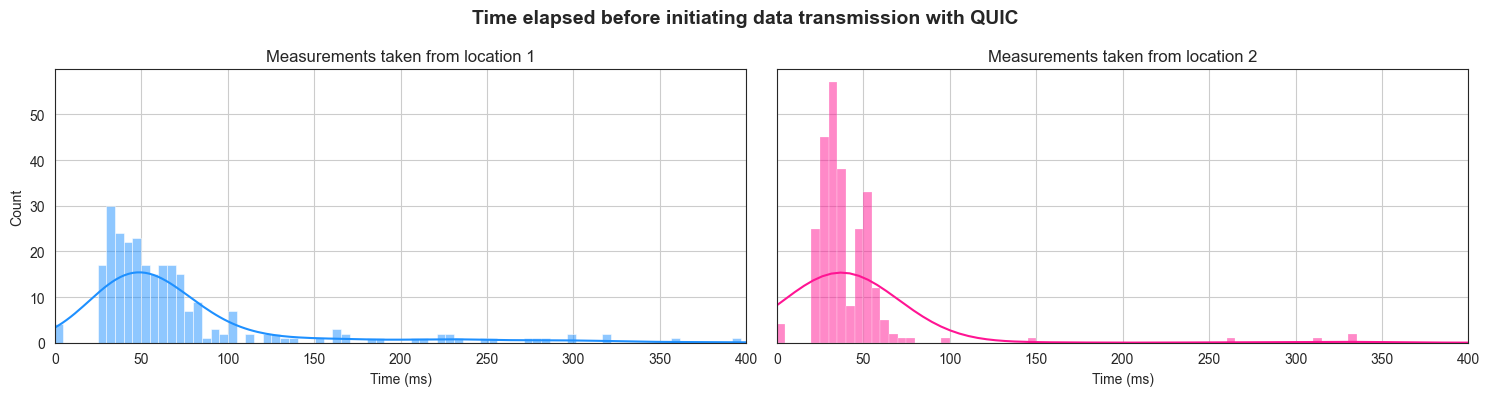

Error  \
                                                                         
0                                                              kthxbye   
1    200:TLS handshake failure (ENCRYPTION_INITIAL) 80: internal error   
2                                                     handshake failed   
3                                                 28:Reject connection   
4                                                         TLS alert 80   
5  28:TLS handshake failure (ENCRYPTION_INITIAL) 40: handshake failure   
6                                                 cannot decrypt token   

  Location         
      home campus  
0      257    256  
1      155    148  
2        2      3  
3        1      2  
4        1      2  
5        2      2  
6        0      2

TLS Cipher Location       
                        home campus
0  Some(AES256_GCM)       70     70
1  Some(AES128_GCM)      191    190

In [91]:
#print("Average time to complete handshake: ", getMeanTime(handshake_times), "ms")
#generateHandshakeTimeDistribution(handshake_times)
#generateHandshakeTimeDistribution(handshake_times, 1, "Connection Establishment", "QUIC")
#generateHandshakeTimeDistribution(tls_handshake_times, 1, "TLS", "QUIC")
generateHandshakeTimeDistribution(time_to_data_transfer, proto="QUIC")

getTLSErrors(error_reasons)
getTLSEstablishedInfo(tls_established)

In [ ]:


"""
TLS:

parameters_set
key_updated & key_discarded : tls can trigger
crypto_error

packet_received, raw, frames -> [{frame_type: "connection_close", "reason": "CONTAINS TLS"}]
handshake_failure: Indicates that the sender was unable to negotiate an acceptable set of security parameters 
given the options available. This is a fatal error.

internal_error: An internal error unrelated to the peer or the correctness of the protocol makes it impossible 
to continue, such as a memory allocation failure. The error is not related to protocol. 
This message is always fatal.

"""

In [8]:
import dpkt
from scapy.all import *
import libpcap


c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\ipsec.py:471: CryptographyDeprecationWarning: Blowfish has been deprecated
  cipher=algorithms.Blowfish,
c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\ipsec.py:485: CryptographyDeprecationWarning: CAST5 has been deprecated
  cipher=algorithms.CAST5,
ERROR: Loading module scapy.layers.ssl_tls
Traceback (most recent call last):
  File "c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\main.py", line 163, in _load
    mod = importlib.import_module(module)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1206, in _gcd_import
  File "<frozen importlib._bootstr

In [9]:
def parsePcapFile(path):
    packets = rdpcap(path)
    load_layer("tls")

    connection_establishment_handshake_duration, time_before_data_transfer = findHandshakeTime(packets)
    tls_packets = findTLSPackets(packets)
    #tls_handshake_time = findTLSHandshakeTime(tls_packets)
    #print(tls_packets)

    return connection_establishment_handshake_duration, time_before_data_transfer, tls_packets

def findHandshakeTime(packets):
    handshake_complete = False
    time_of_first_handshake_packet = 0
    time_of_last_handshake_packet = 0
    initial_time = packets[0].time
    for pkt in packets:
        #print(pkt.summary())
        #print(pkt.src, pkt.dst, pkt.proto, pkt.time)
        #pprint.pprint(pkt.payload)
        if handshake_complete:
            connection_establishment_handshake_duration = (time_of_last_handshake_packet - time_of_first_handshake_packet) * 1000
            time_before_data_transfer = (float(pkt.time) - initial_time) * 1000
            if time_before_data_transfer < 0:
                return None, None
            return connection_establishment_handshake_duration, time_before_data_transfer
        #pprint.pprint(pkt)
        if TCP in pkt:
            #src_ip = pkt[IP].src
            #dst_ip = pkt[IP].dst
            #print(src_ip, dst_ip)
            flag = pkt[TCP].flags
            if flag == "S":
                time_of_first_handshake_packet = float(pkt.time)
            elif flag == "A":
                handshake_complete = True
                time_of_last_handshake_packet = float(pkt.time)

def findTLSPackets(packets):
    tls_packets = [x[TLS] for x in packets if TLS in x]
    return tls_packets

"""def findRTT(path):
    subprocess.run(["tshark", "-r", path, "-Y", "-T", "-e", "tcp.analysis.ack_rtt"], check=True)"""

def findTLSHandshakeTime(packets):
    initial_time = 0
    end_time = packets[-1].time

    for pkt in packets:
        tls_record = pkt[TLS]
        if TLSClientHello in tls_record.msg[0]:
            initial_time = pkt.time
        elif TLSFinished in tls_record.msg[0]:
            end_time = pkt.time
             
    print(end_time, initial_time)
    return abs(end_time - initial_time)
        

In [10]:
handshake_times_tcp = {l:{} for l in locations}
time_before_data_transfer_tcp = {l:{} for l in locations}
tls_packets = {l:{} for l in locations}

In [11]:
current_location = locations[0]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/tcp"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in pcap format or not 
        if file.endswith(".pcap") and os.path.getsize(f"{folder_path}/{file}") > 0: 
            handshake_times_tcp[current_location][folder], time_before_data_transfer_tcp[current_location][folder], tls_packets[current_location][folder] = parsePcapFile(f"{folder_path}/{file}")
            #tcp_RTT_data = findRTT(f"{folder_path}/{file}")
            #print(tcp_RTT_data)
            break

c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\tls\crypto\cipher_block.py:156: CryptographyDeprecationWarning: IDEA has been deprecated
  pc_cls = algorithms.IDEA
c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\tls\crypto\cipher_block.py:162: CryptographyDeprecationWarning: SEED has been deprecated
  pc_cls = algorithms.SEED


In [12]:
current_location = locations[1]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/tcp"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in pcap format or not 
        if file.endswith(".pcap") and os.path.getsize(f"{folder_path}/{file}") > 0: 
            handshake_times_tcp[current_location][folder], time_before_data_transfer_tcp[current_location][folder], tls_packets[current_location][folder] = parsePcapFile(f"{folder_path}/{file}")
            break

[218, 257]


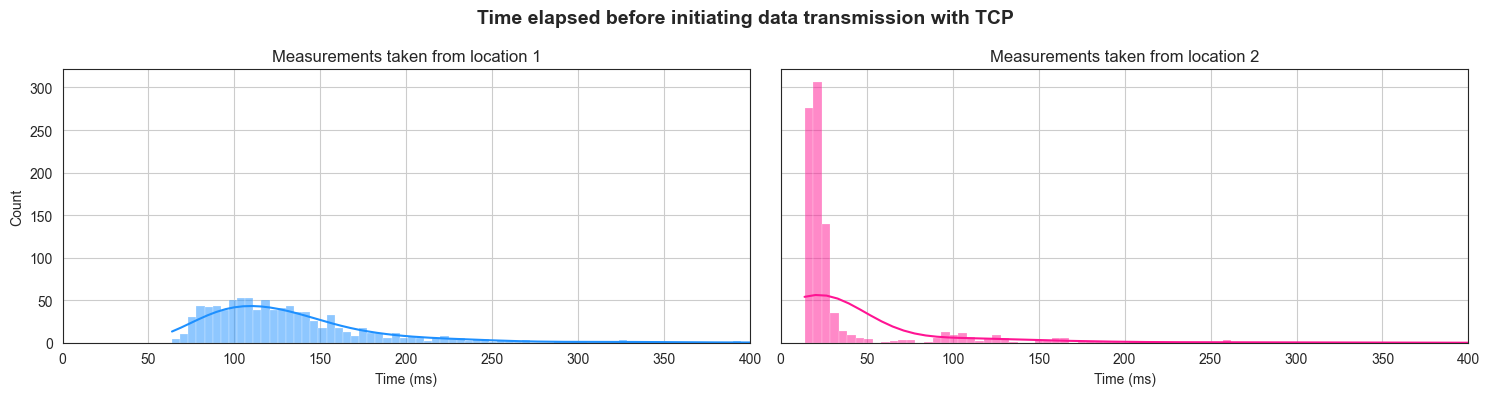

[39, 17] [205, 96]


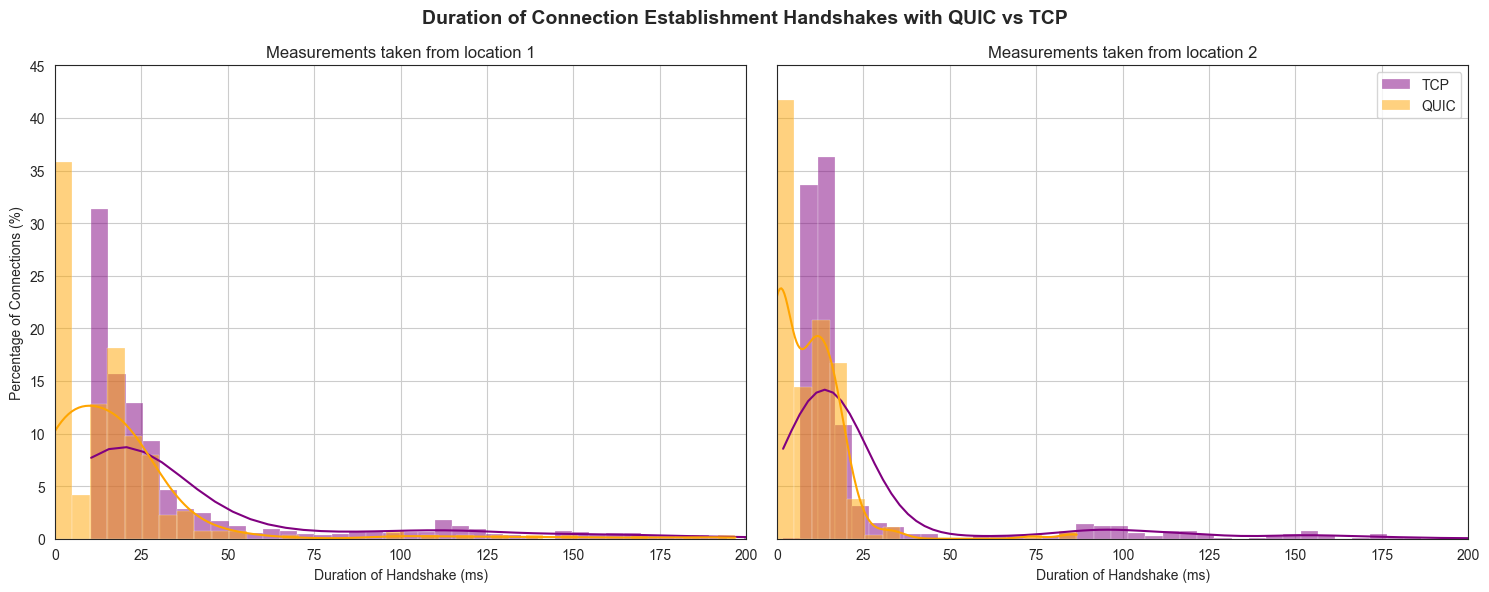

[95, 210] [218, 257]


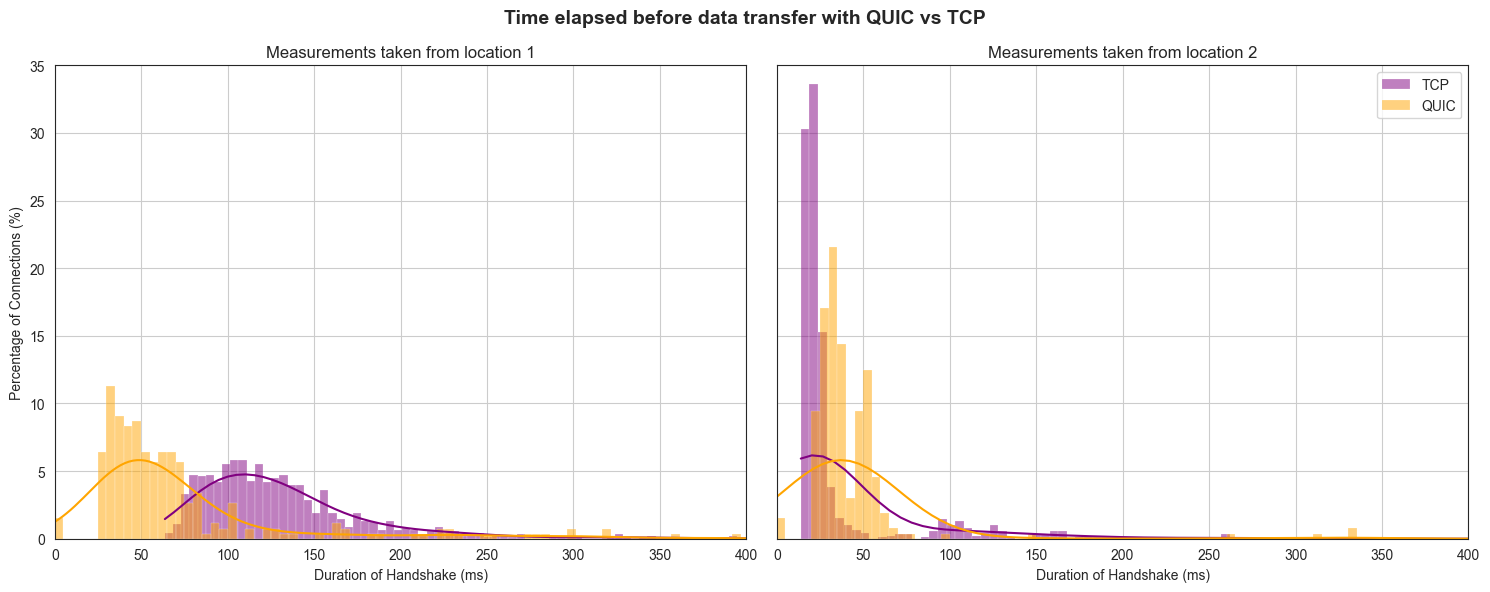

In [100]:
#pprint.pprint(handshake_times)
#generateHandshakeTimeDistribution(handshake_times_tcp, 1, "Connection Establishment", "TCP")
#generateHandshakeTimeDistribution(handshake_times_tcp_tls, 1, "Security", "TLS")
generateHandshakeTimeDistribution(time_before_data_transfer_tcp, proto="TCP")

generateOverlappedHandshakeTimeDistribution(handshake_times, handshake_times_tcp)


generateOverlappedHandshakeTimeDistribution(time_to_data_transfer, time_before_data_transfer_tcp, type=2)

In [190]:
"""pprint.pprint(tls_packets["home"]["www.ebay.com"][0])
print("ClientHello: ", tls_packets["home"]["www.ebay.com"][0].msg[0].ciphers)
pprint.pprint(tls_packets["home"]["www.ebay.com"][1])
print("ServerHello: ", tls_packets["home"]["www.ebay.com"][1].msg[0].cipher)"""

def findTLSVersionAndCiphers():
    tls_versions = {}
    tls_ciphers = {}

    for location in tls_packets:
        for website in tls_packets[location]:
            if len(tls_packets[location][website]) > 1:
                pkt = tls_packets[location][website][1]
                if pkt[TLS].msg:
                    
                    version = pkt[TLS].version if hasattr(pkt[TLS], 'version') else None
                    cipher = pkt[TLS].msg[0].cipher if hasattr(pkt[TLS].msg[0], 'cipher') else None

                    # TLS version
                    if version:
                        if version not in tls_versions:
                            if location == "home":
                                tls_versions[version] = {"home":1, "campus":0}
                            else:
                                tls_versions[version] = {"home":0, "campus":1}
                        else:
                            tls_versions[version][location] += 1
                    # TLS cipher
                    if cipher:
                        if cipher not in tls_ciphers:
                            if location == "home":
                                tls_ciphers[cipher] = {"home":1, "campus":0}
                            else:
                                tls_ciphers[cipher] = {"home":0, "campus":1}
                        else:
                            tls_ciphers[cipher][location] += 1

    return tls_versions, tls_ciphers


def findTLSHandshakeMessages():
    tls_connections = {"(1)client_hello":{"home":0, "campus":0}, 
                       "(2)server_hello":{"home":0, "campus":0}, 
                       "(3)server_key_exchange":{"home":0, "campus":0}, 
                       "(4)client_key_exchange":{"home":0, "campus":0}, 
                       "(5)change_cipher_spec":{"home":0, "campus":0}, 
                       "(6)finished":{"home":0, "campus":0}, 
                       "tls_alert":{"home":0, "campus":0}, 
                       "alert_before_key_exchange":{"home":0, "campus":0}, 
                       "alert_during_key_exchange":{"home":0, "campus":0}, 
                       }

    for location in tls_packets:
        for website in tls_packets[location]:

            client_hello = False
            server_hello = False
            server_key_exchange = False
            client_key_exchange = False
            change_cipher_spec = False
            finished = False
            alert = False
            alert_before_key_exchange = False
            alert_during_key_exchange = False

            for pkt in tls_packets[location][website]:

                tls_record = pkt[TLS]

                if TLSClientHello in tls_record.msg[0]:
                    client_hello = True

                elif TLSServerHello in tls_record.msg[0]:
                    server_hello = True

                elif TLSServerKeyExchange in tls_record.msg[0]:
                    server_key_exchange = True

                elif TLSClientKeyExchange in tls_record.msg[0]:
                    client_key_exchange = True

                elif TLSChangeCipherSpec in tls_record.msg[0]:
                    change_cipher_spec = True

                elif TLSFinished in tls_record.msg[0]:
                    finished = True
                    
                elif TLSAlert in tls_record.msg[0]:
                    alert = True
                    if not client_key_exchange:
                        alert_during_key_exchange = True
                    if not server_key_exchange:
                        alert_before_key_exchange = True

            if client_hello and not server_hello:
                tls_connections["(1)client_hello"][location] += 1
            elif client_hello and server_hello and not server_key_exchange:
                tls_connections["(2)server_hello"][location] += 1
            elif client_hello and server_hello and server_key_exchange and not client_key_exchange:
                tls_connections["(3)server_key_exchange"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and not change_cipher_spec:
                tls_connections["(4)client_key_exchange"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and change_cipher_spec and not finished:
                tls_connections["(5)change_cipher_spec"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and change_cipher_spec and finished:
                tls_connections["(6)finished"][location] += 1

            if alert:
                tls_connections["tls_alert"][location] += 1
                if alert_before_key_exchange:
                    tls_connections["alert_before_key_exchange"][location] += 1
                if alert_during_key_exchange:
                    tls_connections["alert_during_key_exchange"][location] += 1
                    
    return tls_connections
        
def displayDataframe(tls_info, title="TLS"):
    data = []
    for info, counts in tls_info.items():
        if info != "None":
            data.append((info, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([(title, ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)

In [191]:

tls_versions, tls_ciphers = findTLSVersionAndCiphers()
tls_connections = findTLSHandshakeMessages()

displayDataframe(tls_ciphers, "TLS Ciphers")
displayDataframe(tls_versions, "TLS Versions")
displayDataframe(tls_connections, "TLS Handshake Information")


TLS Ciphers Location       
                  home campus
0        4866      493    484
1       49199       55     56
2        4865      217    230
3         159        1      1
4       49196        2      2
5       49195        9      9
6       52392       52     52
7       49200       42     39
8       52393        9      9
9        4867       10     10

TLS Versions Location       
                   home campus
0          771      907    909
1          769        0      1

TLS Handshake Information Location       
                                 home campus
0            (1)client_hello        0      0
1            (2)server_hello      906    907
2     (3)server_key_exchange        0      1
3     (4)client_key_exchange        0      0
4      (5)change_cipher_spec        1      2
5                (6)finished        0      0
6                  tls_alert       24     12
7  alert_before_key_exchange       23     12
8  alert_during_key_exchange        1      0